This notebook is used to assess the *p-value* distributions from the ORA, GSEA, and SPIA tests

In [1]:
import getpass
import itertools as itt
import json
import os
import sys
import time
import warnings
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
import seaborn as sns

from pathway_forte.evaluation.distribution import (
    get_equivalent_mapping_paired_test,
    get_mlp_distribution_tests,
)
from pathway_forte.mappings import get_equivalent_mappings_dict

In [2]:
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline

In [4]:
print(sys.version)

3.7.3 (default, Mar 27 2019, 09:23:39) 
[Clang 10.0.0 (clang-1000.11.45.5)]


In [5]:
print(time.asctime())

Wed May 29 15:10:26 2019


In [6]:
print(getpass.getuser())

cthoyt


In [7]:
equivalent_mappings_dict = get_equivalent_mappings_dict()

In [8]:
output = os.path.join(os.path.expanduser('~'), 'Desktop', 'pf_results', 'output')

In [9]:
databases = ['kegg', 'wikipathways', 'reactome']
datasets = ['BRCA', 'KIRC', 'LIHC', 'PRAD']
prefixes = {
    'kegg': 'hsa', 
    'wikipathways': 'WP',
    'reactome':'R-HSA',
}
stylized_single = {
    'kegg': 'KEGG',
    'reactome': 'Reactome',
    'wikipathways': 'WikiPathways',
    'mpath': 'MPath',
}

stylized_pairs = {
    'kegg_reactome': 'KEGG and\nReactome',
    'reactome_kegg': 'KEGG and\nReactome',
    #
    'reactome_wikipathways': 'Reactome and\nWikiPathways',
    'wikipathways_reactome': 'Reactome and\nWikiPathways',
    #
    'wikipathways_kegg': 'KEGG and\nWikiPathways',
    'kegg_wikipathways': 'KEGG and\nWikiPathways',
    #
    'mpath': 'MPath',
}

DATASET_COLUMN = 'dataset'
DATABASE_COLUMN = 'database'

In [10]:
output_directory = os.path.join(output, 'distributions')
os.makedirs(output_directory, exist_ok=True)

In [11]:
def name_to_database(name):
    for database, prefix in prefixes.items():
        if name.startswith(prefix):
            return database

In [12]:
def mlp(x):
    return -np.log10(x)

In [13]:
def draw_mlp_distributions(df, method, savefig_path=None):
    _df = df.copy()
    _df['Database'] = _df[DATABASE_COLUMN].map(stylized_single.get)
    _df['Comparison'] = _df['comparison'].map(stylized_pairs.get)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 6))
    suptitle = plt.suptitle(f'{method}: distributions of minus-$log_{{10}}$ $p$-$values$', y=1.06, fontsize=22)

    for dataset, ax in zip(datasets, axes.ravel()):
        ax.set_title(dataset, fontdict=dict(fontsize=16))
        sns.violinplot(
            data=_df[_df[DATASET_COLUMN] == dataset],
            y='mlp',
            x='Comparison',
            hue='Database',
            ax=ax,
            cut=0,
        )
        ax.set_ylabel('Minus-$log_{10}$ $p$-$value$')
        ax.set_xlabel('')

    plt.tight_layout()
    if savefig_path:
        plt.savefig(
            savefig_path, 
            dpi=400,
            bbox_inches='tight', 
            bbox_extra_artists=[suptitle],
            pad=0.2
        )

In [14]:
def draw_mlp_distributions_merged(df, method, savefig_path=None):
    _df = df.copy()
    _df['Database'] = _df[DATABASE_COLUMN].map(stylized_single.get)
    
    sns.violinplot(
        data=_df,
        x=DATASET_COLUMN,
        y='mlp',
        hue='Database',
        cut=0,
    )
    plt.title(f'{method}: distributions of minus-$log_{{10}}$ $p$-$values$')
    plt.ylabel('Minus-$log_{10}$ $p$-$value$')
    plt.xlabel('')
    if savefig_path:
        plt.savefig(
            savefig_path, 
            dpi=400,
        )

In [15]:
def draw_p_statistics(df, method, savefig_path=None):
    _df = df.copy()
    _df['Comparison'] = _df.comparison.map(stylized_pairs.get)
    
    sns.catplot(
        data=_df,
        y='wilcoxon_mlp',
        x=DATASET_COLUMN,
        kind='bar',
        hue='Comparison',
        legend_out=False,
    )
    plt.axhline(1.2, linestyle=':')
    title = plt.title(f'Differences in enrichment of pathway\nanalogs across databases for {method}')
    plt.ylabel("Minus-$log_{10}$ $p$-$value$ for Wilcoxon's test")
    plt.xlabel('')
    plt.tight_layout()
    if savefig_path:
        plt.savefig(
            savefig_path, 
            dpi=400,
        )

In [16]:
def draw_double(df1, df2, method, savefig_path=None):
    fig, (lax, rax) = plt.subplots(1, 2, figsize=(12, 5))
    
    suptitle = fig.suptitle(f'Evaluation of {method} results', fontsize=20, y=1.04)
    
    _df1 = df1.copy()
    _df1['Database'] = _df1[DATABASE_COLUMN].map(stylized_single.get)
    lg = sns.violinplot(
        data=_df1,
        x=DATASET_COLUMN,
        y='mlp',
        hue='Database',
        cut=0,
        ax=lax
    )
    lg.set_title('Distributions of minus-$log_{10}$ $p$-$values$')
    lg.set_ylabel(f'{method} minus-$log_{{10}}$ $p$-$value$')
    lg.set_xlabel('')
    
    _df2 = df2.copy()
    _df2['Comparison'] = _df2.comparison.map(stylized_pairs.get)
    
    rg = sns.barplot(
        data=_df2,
        y='wilcoxon_mlp',
        x=DATASET_COLUMN,
        hue='Comparison',
        #legend_out=False,
        ax=rax,
    )
    rax.axhline(1.2, linestyle=':')
    rg.set_title(f'Differences in enrichment of pathway\nanalogs across databases')
    rg.set_ylabel("Minus-$log_{10}$ $p$-$value$ for Wilcoxon's test")
    rg.set_xlabel('')
    
    plt.tight_layout()
    if savefig_path:
        plt.savefig(
            savefig_path, 
            dpi=400,
            bbox_inches='tight', 
            bbox_extra_artists=[suptitle],
            pad=0.2
        )

# ORA

In [17]:
ora_directory = os.path.join(output, 'ora')
assert os.path.exists(ora_directory)

In [18]:
ora_dfs = []

for dataset in datasets:
    # Load MPath results
    ora_mpath_path = os.path.join(ora_directory, f'ora_geometric_analogs_mpath_{dataset.lower()}.tsv')
    df = pd.read_csv(ora_mpath_path, sep='\t')
    df[DATASET_COLUMN] = dataset
    df[DATABASE_COLUMN] = 'mpath'
    ora_dfs.append(df)
    
    # Load paired comparison results
    for db1, db2 in itt.product(databases, repeat=2):
        path = os.path.join(ora_directory, f'ora_geometric_{db1}_{db2}_{dataset.lower()}.tsv')
        if not os.path.exists(path):
            continue
        df = pd.read_csv(path, sep='\t')
        df['comparison'] = f'{db1}_{db2}'
        df[DATASET_COLUMN] = dataset
        ora_dfs.append(df)
        
if not ora_dfs:
    raise RuntimeError(f'Did not find any ORA files in {ora_directory}')

ora_df = pd.concat(ora_dfs)
ora_df['mlp'] = ora_df.pval.map(mlp)
ora_df[[DATASET_COLUMN, 'comparison', DATABASE_COLUMN, 'pathway_id', 'pval', 'mlp']].head()

,dataset,comparison,database,pathway_id,pval,mlp
0,BRCA,NaN,mpath,hsa00020|R-HSA-71403|WP78,0.010830,1.965357
1,BRCA,NaN,mpath,hsa00310|R-HSA-71064,0.000510,3.292033
2,BRCA,NaN,mpath,hsa00562|R-HSA-1483249,0.006072,2.216701
3,BRCA,NaN,mpath,hsa00600|R-HSA-428157|WP1422,0.008478,2.071719
4,BRCA,NaN,mpath,hsa00620|R-HSA-70268,0.000047,4.326101


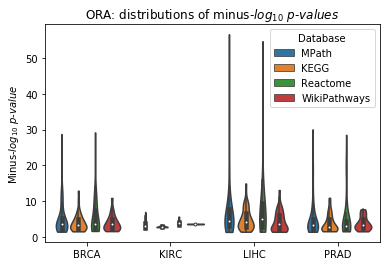

In [19]:
draw_mlp_distributions_merged(
    ora_df, 
    'ORA', 
    os.path.join(output_directory, 'ora_p_value_distributions_merged.png'),
)
plt.show()

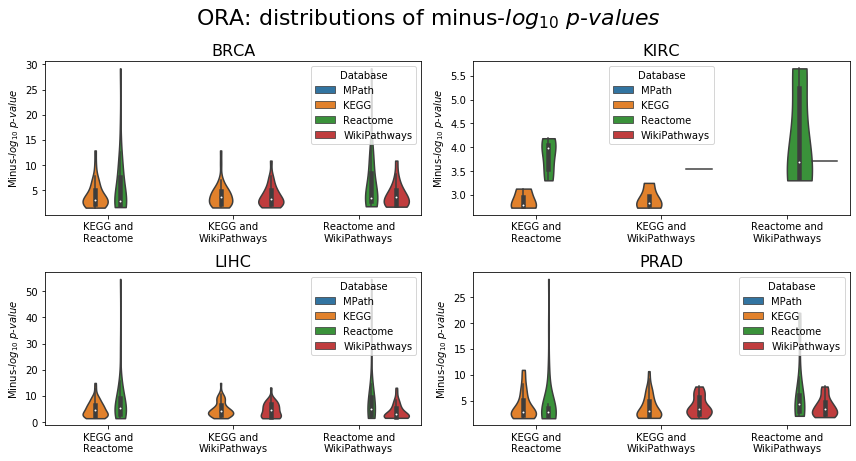

In [20]:
draw_mlp_distributions(
    ora_df[ora_df[DATABASE_COLUMN] != 'MPath'],
    'ORA',
    os.path.join(output_directory, 'ora_p_value_distributions.png'),
)
plt.show()

In [21]:
ora_ks_df = get_mlp_distribution_tests(
    ora_df[ora_df.comparison.notna()], 
    datasets,
    identifier_column_name='pathway_id',
    pval_column_name='pval',
    database_column_name=DATABASE_COLUMN,
    dataset_column_name=DATASET_COLUMN,
    equivalent_mappings_dict=equivalent_mappings_dict,
)
ora_ks_df['method'] = 'ora'
ora_ks_df.to_csv(os.path.join(output_directory, 'ora_p_values.tsv'), sep='\t', index=False)
ora_ks_df

,dataset,comparison,ks_p,ks_mlp,wilcoxon_p,wilcoxon_mlp,ks_paired_p,ks_paired_mlp,wilcoxon_significant,ks_paired_significant,method
0,BRCA,kegg_reactome,0.432213,0.364302,0.610589,0.214251,1.666552e-13,12.778181,False,True,ora
1,BRCA,wikipathways_kegg,0.981955,0.007908,0.361269,0.442169,7.783167e-06,5.108844,False,True,ora
2,BRCA,reactome_wikipathways,0.305373,0.515170,0.000286,3.543825,8.840099e-23,22.053543,True,True,ora
3,KIRC,kegg_reactome,0.014489,1.838971,0.108809,0.963333,0.000000e+00,inf,False,True,ora
4,KIRC,wikipathways_kegg,0.150366,0.822852,0.317311,0.498516,0.000000e+00,inf,False,True,ora
5,KIRC,reactome_wikipathways,0.886795,0.052177,0.027708,1.557397,0.000000e+00,inf,True,True,ora
6,LIHC,kegg_reactome,0.379118,0.421226,0.374056,0.427063,4.734729e-20,19.324705,False,True,ora
7,LIHC,wikipathways_kegg,0.218447,0.660654,0.141315,0.849813,1.788843e-04,3.747428,False,True,ora
8,LIHC,reactome_wikipathways,0.080109,1.096316,0.000289,3.539766,2.508270e-22,21.600626,True,True,ora
9,PRAD,kegg_reactome,0.736750,0.132680,0.015134,1.820054,3.324978e-18,17.478211,True,True,ora


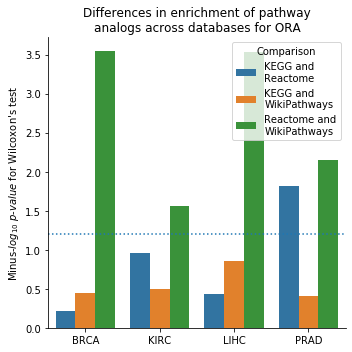

In [22]:
draw_p_statistics(ora_ks_df, 'ORA', os.path.join(output_directory, 'ora_p_value_statistics.png'))
plt.show()

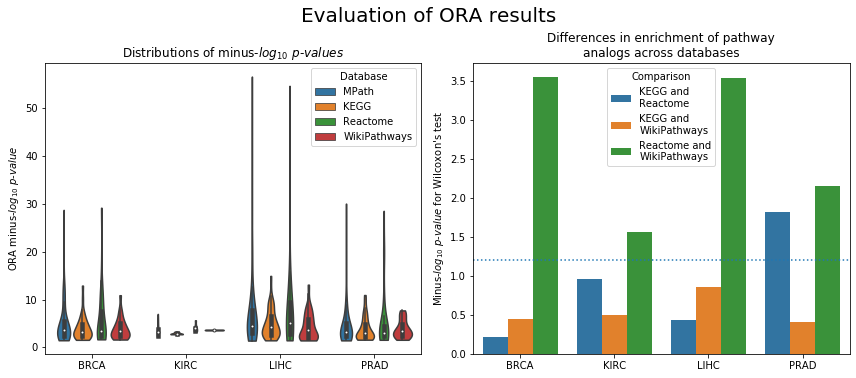

In [23]:
draw_double(ora_df, ora_ks_df, 'ORA', os.path.join(output_directory, 'ora_fig.png'))
plt.show()

# GSEA

In [24]:
gsea_directory = os.path.join(output, 'gsea')
assert os.path.exists(gsea_directory)

In [25]:
gsea_dfs = []

for dataset in datasets:
    path = os.path.join(gsea_directory, f'merge_{dataset.lower()}_29_05_2019.tsv')
    df = pd.read_csv(path, sep='\t')
    df[DATABASE_COLUMN] = 'mpath'
    df[DATASET_COLUMN] = dataset
    gsea_dfs.append(df)

    for db1, db2 in itt.product(databases, repeat=2):
        path = os.path.join(gsea_directory, f'{db1}_{db2}_{dataset.lower()}.tsv')
        if not os.path.exists(path):
            continue
        df = pd.read_csv(path, sep='\t')
        df['comparison'] = f'{db1}_{db2}'
        df[DATABASE_COLUMN] = df['Term'].map(name_to_database)
        df[DATASET_COLUMN] = dataset
        gsea_dfs.append(df)

N_GSEA_PERMUTATIONS = 500
gsea_df = pd.concat(gsea_dfs)
gsea_df['mlp'] = gsea_df.pval.map(lambda x: mlp(x) if x > 0.0 else np.log(N_GSEA_PERMUTATIONS))
del gsea_df['genes']
del gsea_df['ledge_genes']
gsea_df[[DATASET_COLUMN, 'comparison', DATABASE_COLUMN, 'Term', 'pval', 'mlp']].head()

,dataset,comparison,database,Term,pval,mlp
0,BRCA,NaN,mpath,hsa04110|R-HSA-1640170|WP179,0.000000,6.214608
1,BRCA,NaN,mpath,hsa03030|R-HSA-69306|WP466,0.048780,1.311754
2,BRCA,NaN,mpath,hsa04216|WP4545,0.012821,1.892095
3,BRCA,NaN,mpath,hsa00061|WP357,0.016667,1.778151
4,BRCA,NaN,mpath,R-HSA-75109|WP325,0.000000,6.214608


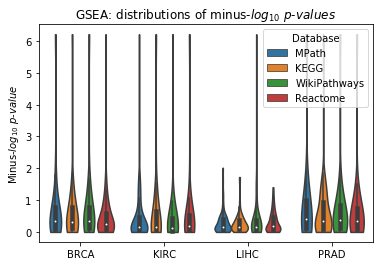

In [26]:
draw_mlp_distributions_merged(
    gsea_df, 
    'GSEA', 
    os.path.join(output_directory, 'gsea_p_value_distributions_merged.png'),
)
plt.show()

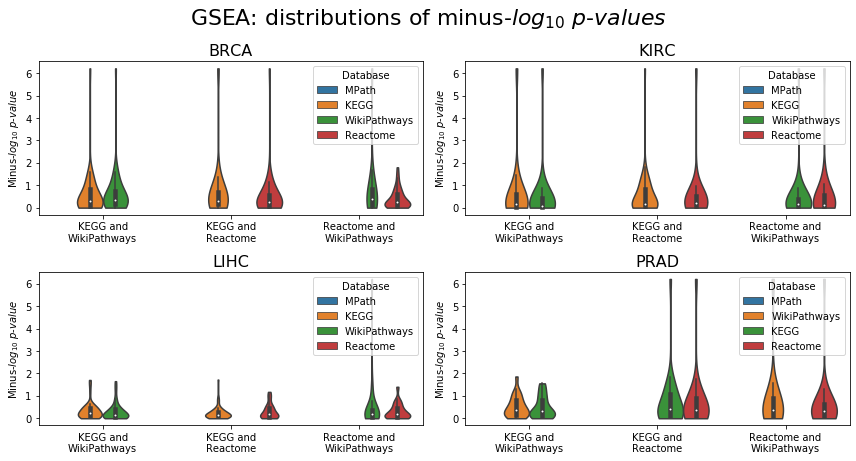

In [27]:
draw_mlp_distributions(
    gsea_df, 
    'GSEA', 
    os.path.join(output_directory, 'gsea_p_value_distributions.png'),
)
plt.show()

In [28]:
gsea_ks_df = get_mlp_distribution_tests(
    gsea_df, 
    datasets,
    identifier_column_name='Term',
    pval_column_name='pval',
    database_column_name=DATABASE_COLUMN,
    dataset_column_name=DATASET_COLUMN,
    equivalent_mappings_dict=equivalent_mappings_dict,
)
gsea_ks_df['method'] = 'gsea'
gsea_ks_df.to_csv(os.path.join(output_directory, 'gsea_p_values.tsv'), sep='\t', index=False)
gsea_ks_df

,dataset,comparison,ks_p,ks_mlp,wilcoxon_p,wilcoxon_mlp,ks_paired_p,ks_paired_mlp,wilcoxon_significant,ks_paired_significant,method
0,BRCA,kegg_wikipathways,0.401543,0.396268,0.389451,0.409547,1.839798e-20,19.735230,False,True,gsea
1,BRCA,kegg_reactome,0.619369,0.208051,0.029370,1.532098,7.224501e-27,26.141192,True,True,gsea
2,BRCA,reactome_wikipathways,0.371364,0.430201,0.371560,0.429971,5.716189e-11,10.242893,False,True,gsea
3,KIRC,kegg_wikipathways,0.859989,0.065507,0.001117,2.952003,NaN,NaN,True,False,gsea
4,KIRC,kegg_reactome,0.474083,0.324146,0.095161,1.021540,1.513400e-26,25.820046,False,True,gsea
5,KIRC,reactome_wikipathways,0.879095,0.055964,0.170294,0.768800,NaN,NaN,False,False,gsea
6,LIHC,kegg_wikipathways,0.655476,0.183443,0.048132,1.317566,2.314013e-32,31.635634,True,True,gsea
7,LIHC,kegg_reactome,0.117687,0.929273,0.596439,0.224434,7.250610e-21,20.139625,False,True,gsea
8,LIHC,reactome_wikipathways,0.879095,0.055964,0.491281,0.308670,1.710266e-19,18.766936,False,True,gsea
9,PRAD,kegg_wikipathways,0.951316,0.021675,0.392930,0.405684,2.967813e-24,23.527563,False,True,gsea


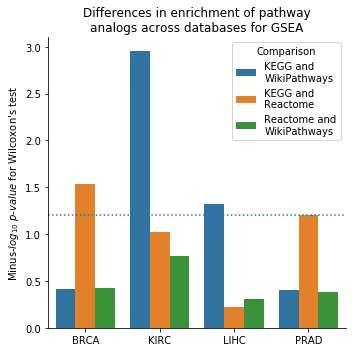

In [29]:
draw_p_statistics(
    gsea_ks_df, 'GSEA', 
    os.path.join(output_directory, 'gsea_p_value_statistics.png'),
)
plt.show()

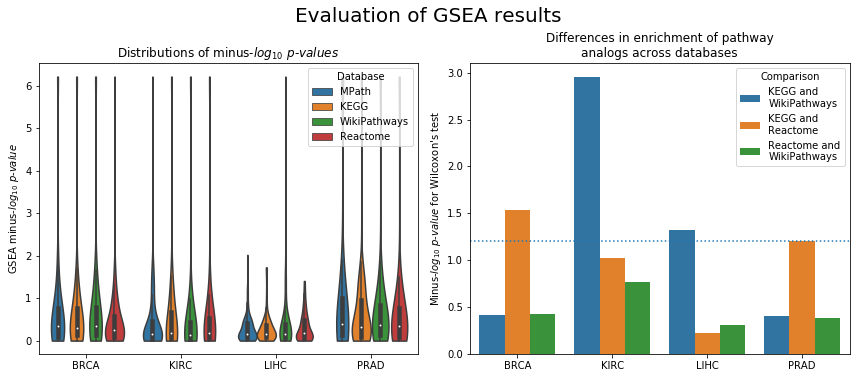

In [30]:
draw_double(gsea_df, gsea_ks_df, 'GSEA', os.path.join(output_directory, 'gsea_fig.png'))
plt.show()

# SPIA

In [31]:
spia_directory = os.path.join(output, 'spia')

In [32]:
spia_dfs = []

for dataset in datasets:
    path = os.path.join(spia_directory, f'{dataset.lower()}_mpath_spia.csv')
    df = pd.read_csv(path)
    df[DATABASE_COLUMN] = 'mpath'
    df[DATASET_COLUMN] = dataset
    spia_dfs.append(df)

    for db1, db2 in itt.product(databases, repeat=2):
        path = os.path.join(spia_directory, f'{dataset.lower()}_{db1}_{db2}_spia.csv')
        if not os.path.exists(path):
            continue
        df = pd.read_csv(path)
        df['comparison'] = f'{db1}_{db2}'
        df[DATABASE_COLUMN] = df['Name'].map(name_to_database)
        df[DATASET_COLUMN] = dataset
        spia_dfs.append(df)

spia_df = pd.concat(spia_dfs)
spia_df['mlp'] = spia_df.pG.map(mlp)
spia_df[[DATASET_COLUMN, 'comparison', DATABASE_COLUMN, 'Name', 'pG', 'mlp']].head()

,dataset,comparison,database,Name,pG,mlp
0,BRCA,NaN,mpath,hsa04510_WP306,6.287952e-19,18.201491
1,BRCA,NaN,mpath,hsa04810_WP51,3.548062e-16,15.450009
2,BRCA,NaN,mpath,hsa04740_R-HSA-381753,3.880843e-13,12.411074
3,BRCA,NaN,mpath,hsa04062_WP3929,1.640665e-11,10.784980
4,BRCA,NaN,mpath,hsa04921_WP2889,6.941049e-11,10.158575


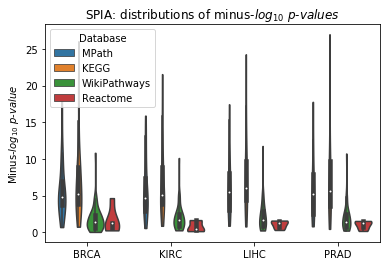

In [33]:
draw_mlp_distributions_merged(
    spia_df, 'SPIA', 
    os.path.join(output_directory, 'spia_p_value_distributions_merged.png'),
)
plt.show()

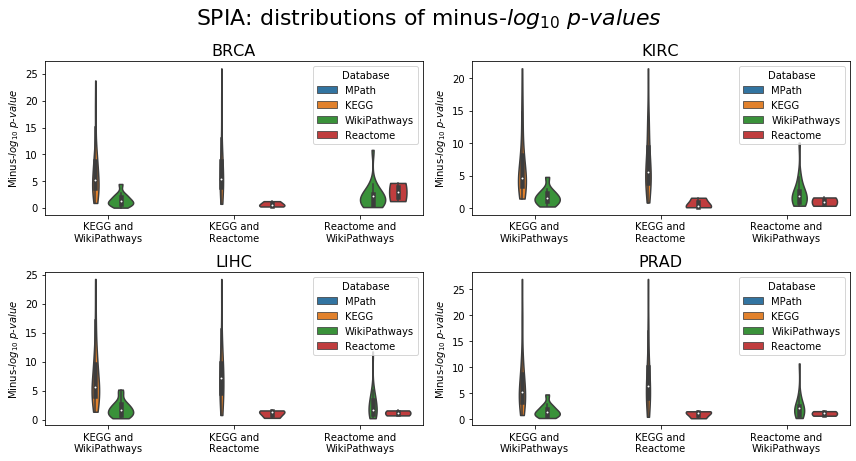

In [34]:
draw_mlp_distributions(
    spia_df, 'SPIA', 
    os.path.join(output_directory, 'spia_p_value_distributions.png'),
)
plt.show()

In [35]:
spia_ks_df = get_mlp_distribution_tests(
    spia_df, 
    datasets,
    identifier_column_name='Name',
    pval_column_name='pG',
    database_column_name=DATABASE_COLUMN,
    dataset_column_name=DATASET_COLUMN,
    equivalent_mappings_dict=equivalent_mappings_dict,
)
spia_ks_df['method'] = 'spia'
spia_ks_df.to_csv(os.path.join(output_directory, 'spia_p_value_statistics.tsv'), sep='\t', index=False)
spia_ks_df

,dataset,comparison,ks_p,ks_mlp,wilcoxon_p,wilcoxon_mlp,ks_paired_p,ks_paired_mlp,wilcoxon_significant,ks_paired_significant,method
0,BRCA,kegg_wikipathways,5.156326e-07,6.287660,9.087312e-08,7.041565,1.858888e-60,59.730747,True,True,spia
1,BRCA,kegg_reactome,6.610303e-03,2.179779,2.477028e-07,6.606069,0.000000e+00,inf,True,True,spia
2,BRCA,reactome_wikipathways,7.244088e-01,0.140016,1.797125e-01,0.745422,0.000000e+00,inf,False,True,spia
3,KIRC,kegg_wikipathways,5.156326e-07,6.287660,9.087312e-08,7.041565,1.858888e-60,59.730747,True,True,spia
4,KIRC,kegg_reactome,6.610303e-03,2.179779,2.477028e-07,6.606069,0.000000e+00,inf,True,True,spia
5,KIRC,reactome_wikipathways,5.212395e-01,0.282963,1.797125e-01,0.745422,0.000000e+00,inf,False,True,spia
6,LIHC,kegg_wikipathways,5.402924e-07,6.267371,8.387355e-08,7.076375,1.858888e-60,59.730747,True,True,spia
7,LIHC,kegg_reactome,6.610303e-03,2.179779,2.477028e-07,6.606069,0.000000e+00,inf,True,True,spia
8,LIHC,reactome_wikipathways,2.954444e-01,0.529524,1.797125e-01,0.745422,0.000000e+00,inf,False,True,spia
9,PRAD,kegg_wikipathways,5.156326e-07,6.287660,9.843673e-08,7.006843,5.109674e-49,48.291607,True,True,spia


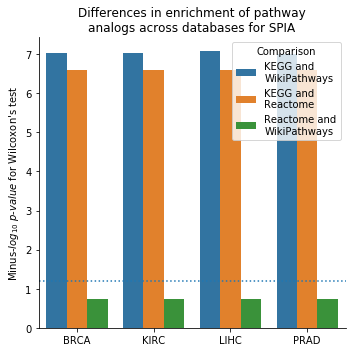

In [36]:
draw_p_statistics(
    spia_ks_df, 'SPIA', 
    os.path.join(output_directory, 'spia_p_value_statistics.png'),
)
plt.show()

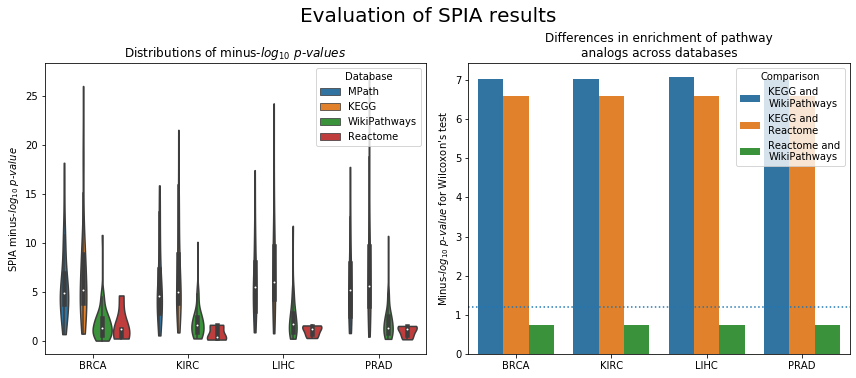

In [37]:
draw_double(spia_df, spia_ks_df, 'SPIA', os.path.join(output_directory, 'spia_fig.png'))
plt.show()